# Calculation of the TOV for the EOS: NSM changepoint kernel

## Alexandra Semposki

### Date: 27 January 2025

This notebook calculates the TOV equations for given data from the EOS from Bayesian model mixing. It then compares the 20n0 and 40n0 cutoff cases, and plots them in comparison to the NICER and LIGO data in the M-R posterior.

In [1]:
# import packages
%load_ext autoreload
%autoreload 2

import pickle
import sys
sys.path.append('../src/')
import scipy as sp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

from gp_utils import GaussianProcessRegressor2dNoise
from eos_utils import *
from tov_utils import *
from scripts import *

import sys
sys.path.append('../../../TOV_Solver')
from TOV_class import TOVsolver

# set params for plotting
setup_rc_params()

# define saturation up here
n0 = 0.164

# color plotting assistance
orders = [0, 1, 2, 3]
order_labels = [r'$\chi$EFT (N$^{3}$LO)', r'pQCD (N$^{2}$LO)', 'Mixed Model']
color_list = ['Reds', 'Blues','Purples', 'Oranges', 'Greens', 'Greys']
cmaps = [plt.get_cmap(name) for name in color_list[:len(orders)]]
colors = [cmap(0.7 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
light_colors = [lighten_color(color, 0.5) for color in colors]
dark_colors = [lighten_color(color, 1.5) for color in colors]

In [2]:
# load NICER data
miller = np.loadtxt('../data/NICER_data/NICER+XMM_J0740_RM.txt')
miller_0030_2 = np.loadtxt('../data/NICER_data/J0030_2spot_RM.txt')
miller_0030_3 = np.loadtxt('../data/NICER_data/J0030_3spot_RM.txt')

# load NICER J0437 data
j0437 = np.loadtxt('../data/NICER_data/J0437_data/samples/J0437_3C50_BKG_AGN_hiMN_lowXPSI_wmrsamples.dat')

In [3]:
# load in the LIGO data from the folder
df_insens = pd.read_csv('../data/LIGO_data/EoS-insensitive_posterior_samples.dat', sep='\s+')
display(df_insens)

df_maxmass = pd.read_csv('../data/LIGO_data/Parametrized-EoS_maxmass_posterior_samples.dat', sep='\s+')
display(df_maxmass)

# convert to a dict
LIGO_insens = df_insens.to_dict('list')
LIGO_maxmass = df_maxmass.to_dict('list')

,m1_source_frame_Msun,m2_source_frame_Msun,Lambda1,Lambda2,Radius1_km,Radius2_km
0,1.543236,1.205749,97.068200,248.541197,10.730811,9.358211
1,1.482590,1.253115,19.677667,280.480973,8.186003,9.833989
2,1.541613,1.206940,31.524739,235.511540,9.149591,9.373914
3,1.562878,1.191476,49.572338,409.681755,9.951128,10.102846
4,1.656298,1.128266,27.441288,246.930128,9.602853,9.395534
...,...,...,...,...,...,...
2916,1.508332,1.232504,91.421409,229.584025,10.730333,9.901073
2917,1.602577,1.163587,59.820623,266.473512,10.058355,9.314710
2918,1.561251,1.192543,12.951990,234.310549,8.475787,9.328835
2919,1.476021,1.258401,126.699863,346.595638,10.741590,10.844589


,m1_source_frame_Msun,m2_source_frame_Msun,Lambda1,Lambda2,Radius1_km,Radius2_km
0,1.637296,1.140765,66.373870,723.523060,10.887391,11.097352
1,1.612825,1.156845,191.207304,1335.339873,12.402063,12.349246
2,1.563015,1.191614,200.526550,1156.272842,12.285450,12.501216
3,1.625307,1.148567,134.833116,1439.597356,12.141489,12.627265
4,1.625909,1.148243,177.099466,1428.281697,12.399686,12.426146
...,...,...,...,...,...,...
2391,1.456157,1.275411,271.138172,593.167994,11.771023,11.732749
2392,1.363036,1.361102,275.144868,277.559025,11.146219,11.146212
2393,1.547311,1.202998,308.382837,1352.958123,12.800400,12.770993
2394,1.379074,1.345569,253.244553,293.279550,11.077769,11.070750


In [4]:
# LIGO data
x11 = np.asarray(LIGO_maxmass['Radius1_km'])
y11 = np.asarray(LIGO_maxmass['m1_source_frame_Msun'])
x22 = np.asarray(LIGO_maxmass['Radius2_km'])
y22 = np.asarray(LIGO_maxmass['m2_source_frame_Msun'])

In [51]:
# 20n0, no mean, no data, reduced
filename20 = 'NSM_changepoint_data_20n0_3_False'
filename40 = 'NSM_changepoint_data_20n0_3_True'
with open('../data/pickled_data/'+filename20+'.pkl', 'rb') as fp:
    density20 = pickle.load(fp)
    edensdict20 = pickle.load(fp)
    pressuredict20 = pickle.load(fp)
    cs2dict20 = pickle.load(fp)

# 40n0, no mean, no data, reduced
with open('../data/pickled_data/'+filename40+'.pkl', 'rb') as fp:
    density40 = pickle.load(fp)
    edensdict40 = pickle.load(fp)
    pressuredict40 = pickle.load(fp)
    cs2dict40 = pickle.load(fp)
    
# look at the data types here and keys
print(edensdict20.keys())
print(edensdict40.keys())

dict_keys(['mean', 'std', 'samples'])
dict_keys(['mean', 'std', 'samples'])


In [52]:
# organize data for the TOV data helper
pressuresamples20 = np.column_stack((pressuredict20['mean']-pressuredict20['std_dev'], \
                                     pressuredict20['mean'], pressuredict20['mean']+pressuredict20['std_dev']))
pressuresamples40 = np.column_stack((pressuredict40['mean']-pressuredict40['std_dev'], \
                                     pressuredict40['mean'], pressuredict40['mean']+pressuredict40['std_dev']))
edenssamples20 = np.column_stack((edensdict20['mean']-edensdict20['std'], \
                                  edensdict20['mean'], edensdict20['mean']+edensdict20['std']))
edenssamples40 = np.column_stack((edensdict40['mean']-edensdict40['std'], \
                                  edensdict40['mean'], edensdict40['mean']+edensdict40['std']))

In [53]:
# create TOV data and feed envelopes
tovpressuredict20 = {
    'dens': density20,
    'samples': pressuresamples20
}

tovpressuredict40 = {
    'dens': density40,
    'samples': pressuresamples40
}

tovdict20 = tov_data(edenssamples20, tovpressuredict20, save=True, \
                    filepath='../data/TOV_data/tov_{}.npz'.format(filename20))
tovdict40 = tov_data(edenssamples40, tovpressuredict40, save=True, \
                    filepath='../data/TOV_data/tov_{}.npz'.format(filename40))

I'm done!
I'm done!


In [54]:
# call the solver once, send all data directly
tov20 = TOVsolver(eos_filepath='../data/TOV_data/tov_{}.npz'.format(filename20), tidal=False, moment=False)
tov40 = TOVsolver(eos_filepath='../data/TOV_data/tov_{}.npz'.format(filename40), tidal=False, moment=False)

# call routine once (should do its thing...check why central pressures are the same for different ones)
rad20, prescent20, mass20 = tov20.tov_routine(verbose=False, write_to_file=False)
rad40, prescent40, mass40 = tov40.tov_routine(verbose=False, write_to_file=False)

Woo it worked!
Woo it worked!
Radius:  9.103494585600004 Maximum mass:  1.5157317667590624 Central pressure:  743.0010894672662
Radius:  9.090093136800002 Maximum mass:  1.5170475190124122 Central pressure:  743.0010894672662
Radius:  9.058823089600002 Maximum mass:  1.5149229046945416 Central pressure:  743.0010894672662
Radius:  9.0409544912 Maximum mass:  1.4633704692728078 Central pressure:  636.240764772628
Radius:  8.991815845600001 Maximum mass:  1.4446994268407252 Central pressure:  636.240764772628
Radius:  8.9382100504 Maximum mass:  1.4268452953454036 Central pressure:  636.240764772628


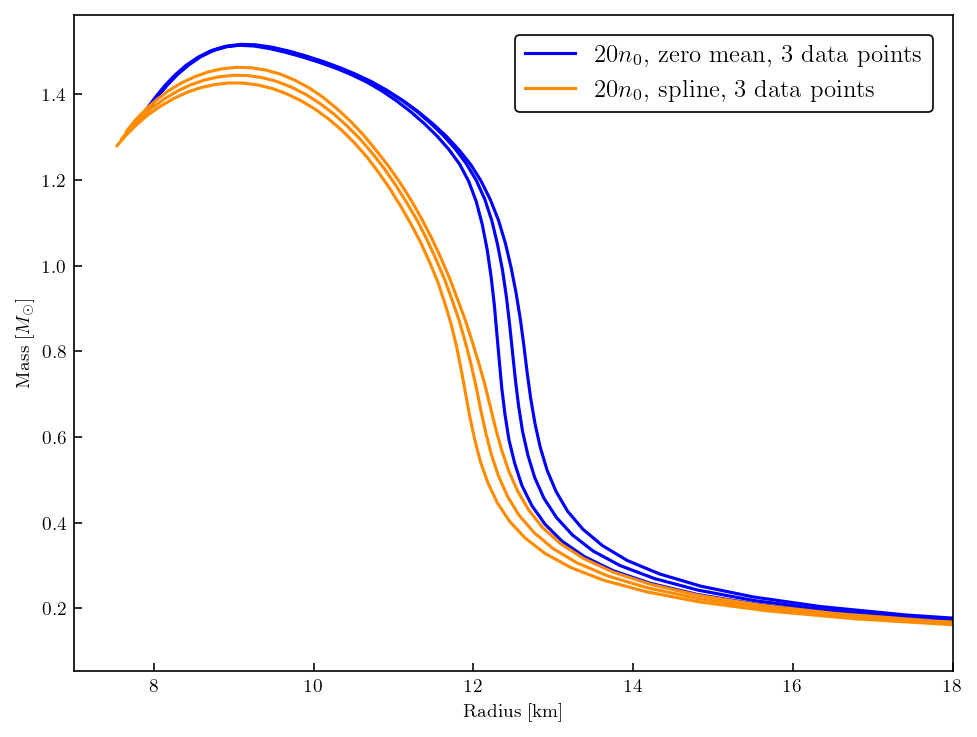

In [58]:
# plot these envelopes for each case (they will overlap, it's fine for now...)
[plt.plot(rad20[:,i+1], mass20[:,i+1], color='blue') for i in range(2)]
plt.plot(rad20[:,0], mass20[:,0], color='blue', label=r'$20n_0$, zero mean, 3 data points')
[plt.plot(rad40[:,i+1], mass40[:,i+1], color='darkorange') for i in range(2)]
plt.plot(rad40[:,0], mass40[:,0], color='darkorange', label=r'$20n_0$, spline, 3 data points')
plt.xlabel(r'Radius [km]')
plt.ylabel(r'Mass [$M_{\odot}$]')
plt.xlim(7.0, 18.0)
plt.legend(fontsize=12)
plt.show()

(3, 944)
(944, 3)
(3, 944)
(944, 3)


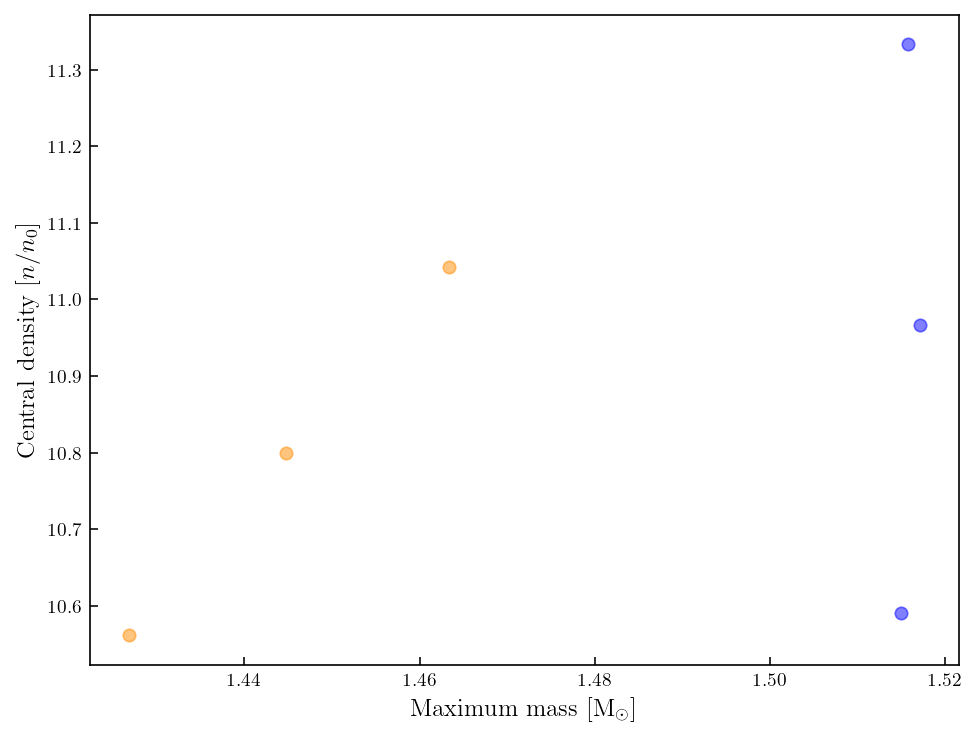

In [61]:
# central densities
cdens_20n0 = tov20.central_dens()
max_mass_20n0 = tov20.max_mass_arr
cdens_40n0 = tov40.central_dens()
max_mass_40n0 = tov40.max_mass_arr

# plot the maximum mass vs. central density
plt.scatter(max_mass_20n0, cdens_20n0/n0, marker='o', color='blue', alpha=0.5)
plt.scatter(max_mass_40n0, cdens_40n0/n0, marker='o', color='darkorange', alpha=0.5)
plt.ylabel(r'Central density [$n/n_{0}]$', fontsize=12)
plt.xlabel(r'Maximum mass [M$_\odot$]', fontsize=12)
plt.show()

In [64]:
# exclude the points with less than 2.0 maximum mass and compare in histogram below
ind_20 = []
ind_40 = []
for i in range(len(max_mass_20n0)):
    if max_mass_20n0[i] < 2.0:
        ind_20.append(i)
for j in range(len(max_mass_40n0)):
    if max_mass_40n0[j] < 2.0:
        ind_40.append(j)

In [66]:
# delete the central densities that we don't want to keep
cdens_20_reduced = np.delete(cdens_20n0, ind_20)
cdens_40_reduced = np.delete(cdens_40n0, ind_40)

## Histogram (all stars)

/var/folders/q4/wyq6nf1d29n2gxrsbvs1m01r0000gn/T/ipykernel_63329/163007.py:61: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


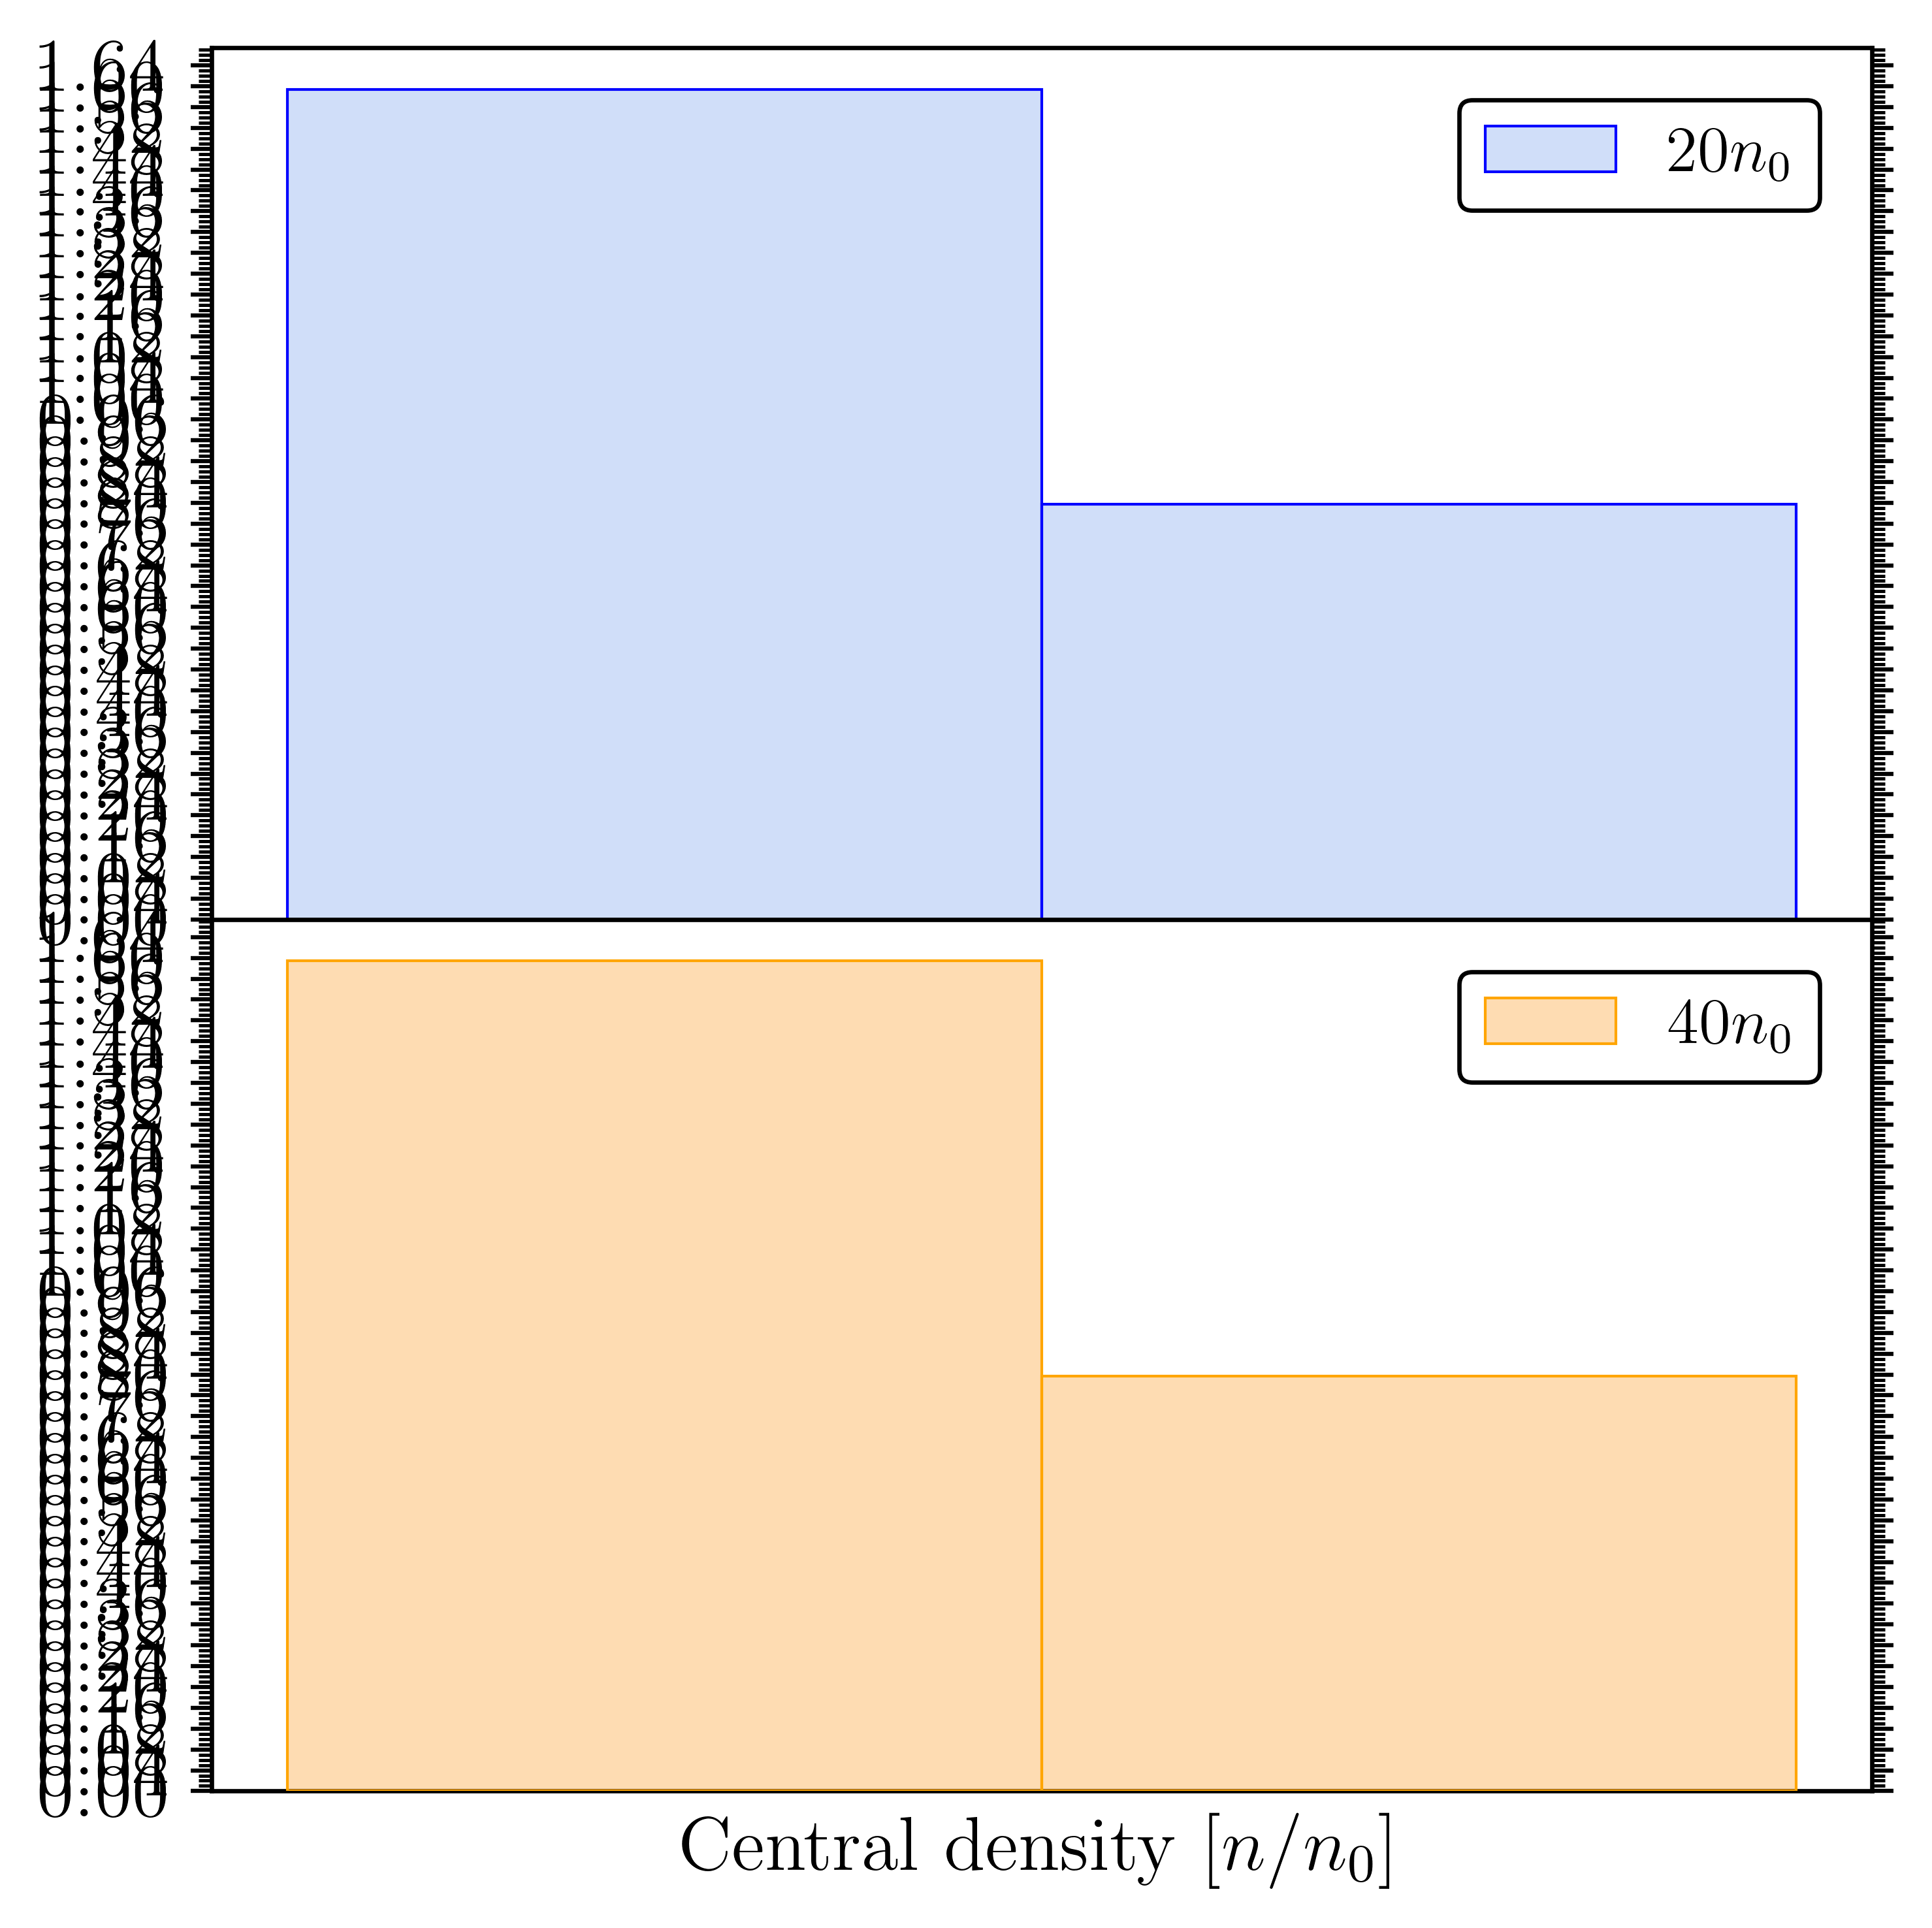

In [70]:
# bin the central densities and see what happens
fig, ax = plt.subplots(2, 1, figsize=(5,5), dpi=600, sharex=True)
ax[0].tick_params(axis='both', which='major', direction='out', labelsize=14, right=True)
ax[0].tick_params(axis='both', which='minor', direction='out', labelsize=14, right=True)
ax[0].yaxis.set_major_locator(MultipleLocator(0.04))
ax[0].yaxis.set_minor_locator(AutoMinorLocator(4))
ax[0].xaxis.set_major_locator(MultipleLocator(5))
ax[0].xaxis.set_minor_locator(AutoMinorLocator(3))
ax[1].tick_params(axis='both', which='major', direction='out', labelsize=14, right=True)
ax[1].tick_params(axis='both', which='minor', direction='out', labelsize=14, right=True)
ax[1].yaxis.set_major_locator(MultipleLocator(0.04))
ax[1].yaxis.set_minor_locator(AutoMinorLocator(4))
ax[1].xaxis.set_major_locator(MultipleLocator(5))
ax[1].xaxis.set_minor_locator(AutoMinorLocator(3))

cdens_scaled = cdens_20n0/n0
cdens_scaled_40 = cdens_40n0/n0

# global dudes
maximum_cdens = max(max(cdens_scaled), max(cdens_scaled_40))
minimum_cdens = min(min(cdens_scaled), min(cdens_scaled_40))

# consistent binning
def freedman_diaconis_bin_width(data):
    q75, q25 = np.percentile(data, [75, 25])
    iqr = q75 - q25
    return 2 * iqr / np.cbrt(len(data))

bin_width = freedman_diaconis_bin_width(np.concatenate([cdens_scaled, cdens_scaled_40]))
bins = np.arange(minimum_cdens, maximum_cdens + bin_width, bin_width)

# 20n0 figure
n_20n0, bins_20n0, patches_20n0 = ax[0].hist(
    cdens_scaled, 
    bins=bins, 
    density=True, 
    edgecolor='blue',
    linewidth=0.5,
    label=r'$20n_{0}$',
    zorder=1
)

# 40n0 figure (separate for now)
n_40n0, bins_40n0, patches_40n0 = ax[1].hist(
    cdens_scaled_40,
    bins=bins,
    density=True,
    edgecolor='orange',
    linewidth=0.5,
    label=r'$40n_{0}$',
    zorder=10
)

for patch in patches_20n0:
    patch.set_facecolor((100/256, 149/256, 237/256, 0.3))  # cornflower blue
for patch in patches_40n0:
    patch.set_facecolor((255/256, 140/256, 0/256, 0.3))  # dark orange
ax[1].set_xlabel(r'Central density [$n/n_0$]', fontsize=14)
ax[0].legend(fontsize=12)
ax[1].legend(fontsize=12)
fig.tight_layout()
plt.subplots_adjust(hspace=0)
fig.savefig('histogram_central_densities.png')
plt.show()

/var/folders/q4/wyq6nf1d29n2gxrsbvs1m01r0000gn/T/ipykernel_9953/1171273035.py:50: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


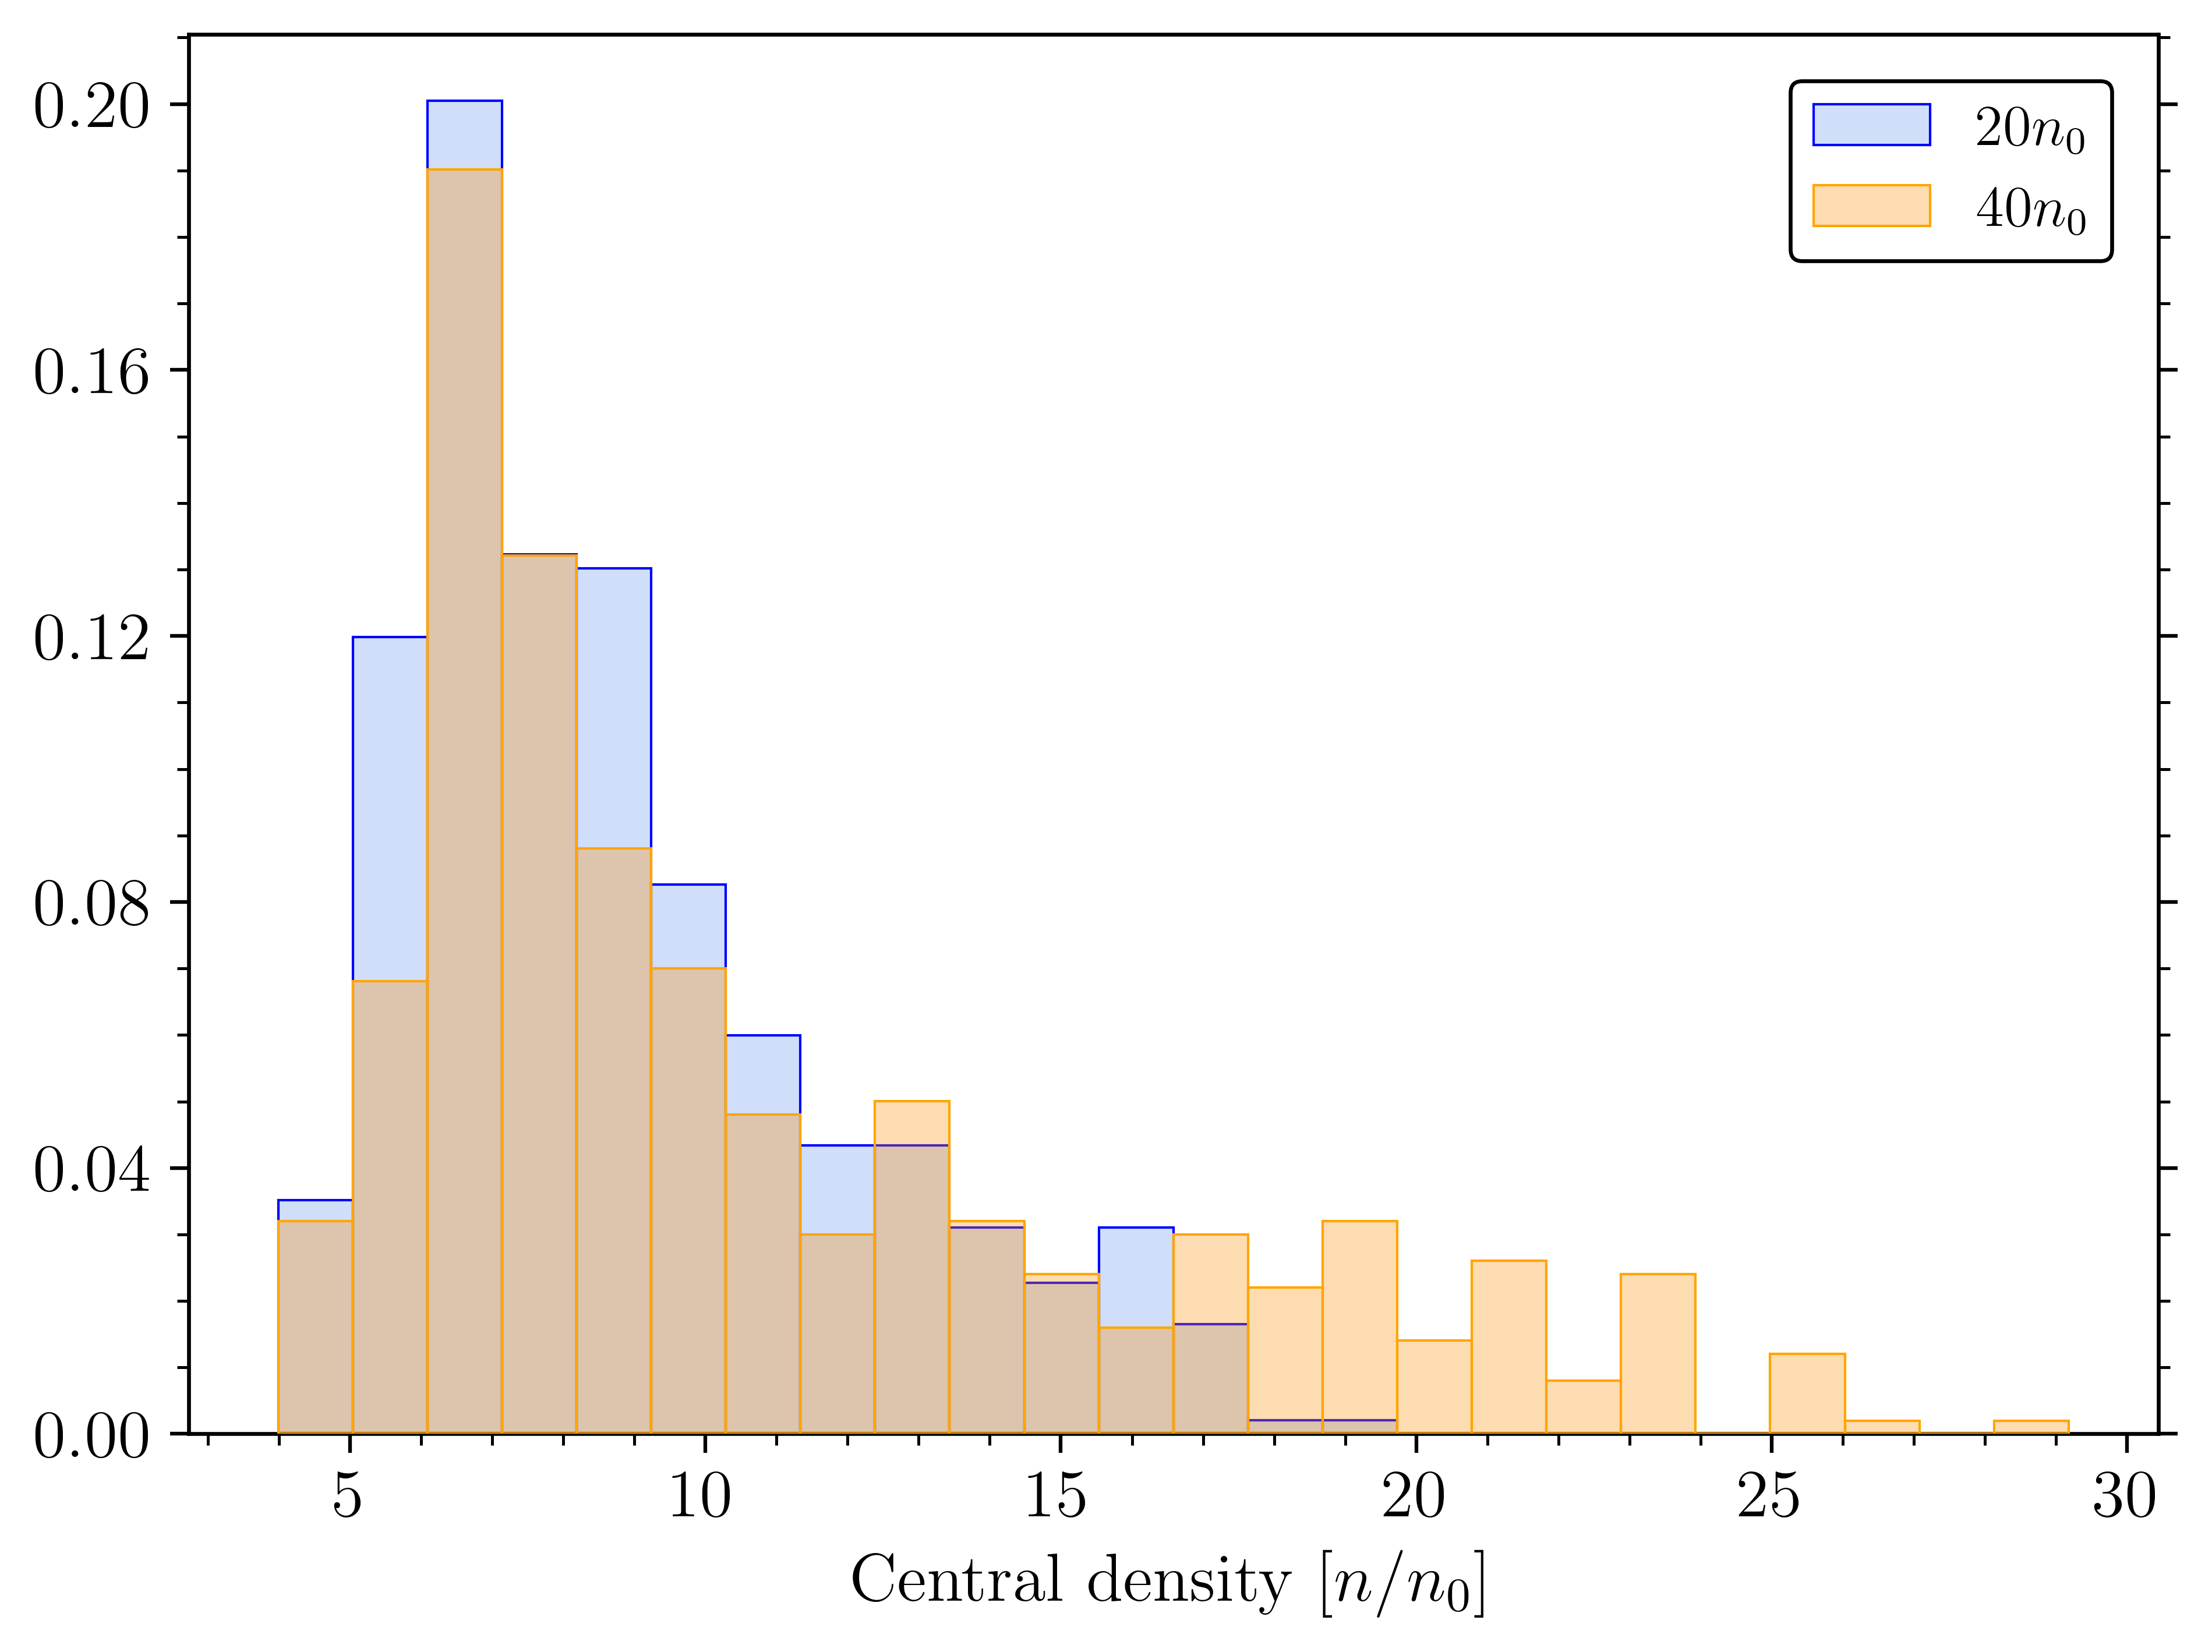

In [211]:
# histogram all on one plot from above
# bin the central densities and see what happens
fig = plt.figure(dpi=600)
ax = plt.axes()
ax.tick_params(axis='both', which='major', direction='out', labelsize=14, right=True)
ax.tick_params(axis='both', which='minor', direction='out', labelsize=14, right=True)
ax.yaxis.set_major_locator(MultipleLocator(0.04))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(AutoMinorLocator(5))

cdens_scaled = cdens_20n0/n0
cdens_scaled_40 = cdens_40n0/n0

# global dudes
maximum_cdens = max(max(cdens_scaled), max(cdens_scaled_40))
minimum_cdens = min(min(cdens_scaled), min(cdens_scaled_40))

bin_width = freedman_diaconis_bin_width(np.concatenate([cdens_scaled, cdens_scaled_40]))
bins = np.arange(minimum_cdens, maximum_cdens + bin_width, bin_width)

# 20n0 figure
n_20n0, bins_20n0, patches_20n0 = ax.hist(
    cdens_scaled, 
    bins=bins, 
    density=True, 
    edgecolor='blue',
    linewidth=0.5,
    label=r'$20n_{0}$',
    zorder=1
)

# 40n0 figure (separate for now)
n_40n0, bins_40n0, patches_40n0 = ax.hist(
    cdens_scaled_40,
    bins=bins,
    density=True,
    edgecolor='orange',
    linewidth=0.5,
    label=r'$40n_{0}$',
    zorder=10
)

for patch in patches_20n0:
    patch.set_facecolor((100/256, 149/256, 237/256, 0.3))  # cornflower blue
for patch in patches_40n0:
    patch.set_facecolor((255/256, 140/256, 0/256, 0.3))  # dark orange
ax.set_xlabel(r'Central density [$n/n_0$]', fontsize=14)
ax.legend(fontsize=12)
fig.tight_layout()
plt.subplots_adjust(hspace=0)
fig.savefig('histogram_central_densities_one_plot.png')
plt.show()

In [71]:
max_rad20, max_cpres20, max_mass20 = tov20.max_arrays()
max_rad40, max_cpres40, max_mass40 = tov40.max_arrays()

In [176]:
# save these central densities before you lose your mind
np.savez('cdens_20n0.npz', max_rad=max_rad20, max_cpres=max_cpres20, \
         max_mass=max_mass20, cdens=cdens_20n0_real)

np.savez('rpm_20n0.npz', rad=radius_data_20, cpres=pressure_data_20, mass=mass_data_20)

# save now the 40n0 stuff just in case
np.savez('cdens_40n0.npz', max_rad=max_rad40, max_cpres=max_cpres40, \
         max_mass=max_mass40, cdens=cdens_40n0)

np.savez('rpm_40n0.npz', rad=radius_data_40, cpres=pressure_data_40, mass=mass_data_40)

## Histogram (reduced stars)

/var/folders/q4/wyq6nf1d29n2gxrsbvs1m01r0000gn/T/ipykernel_9953/1360433307.py:61: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


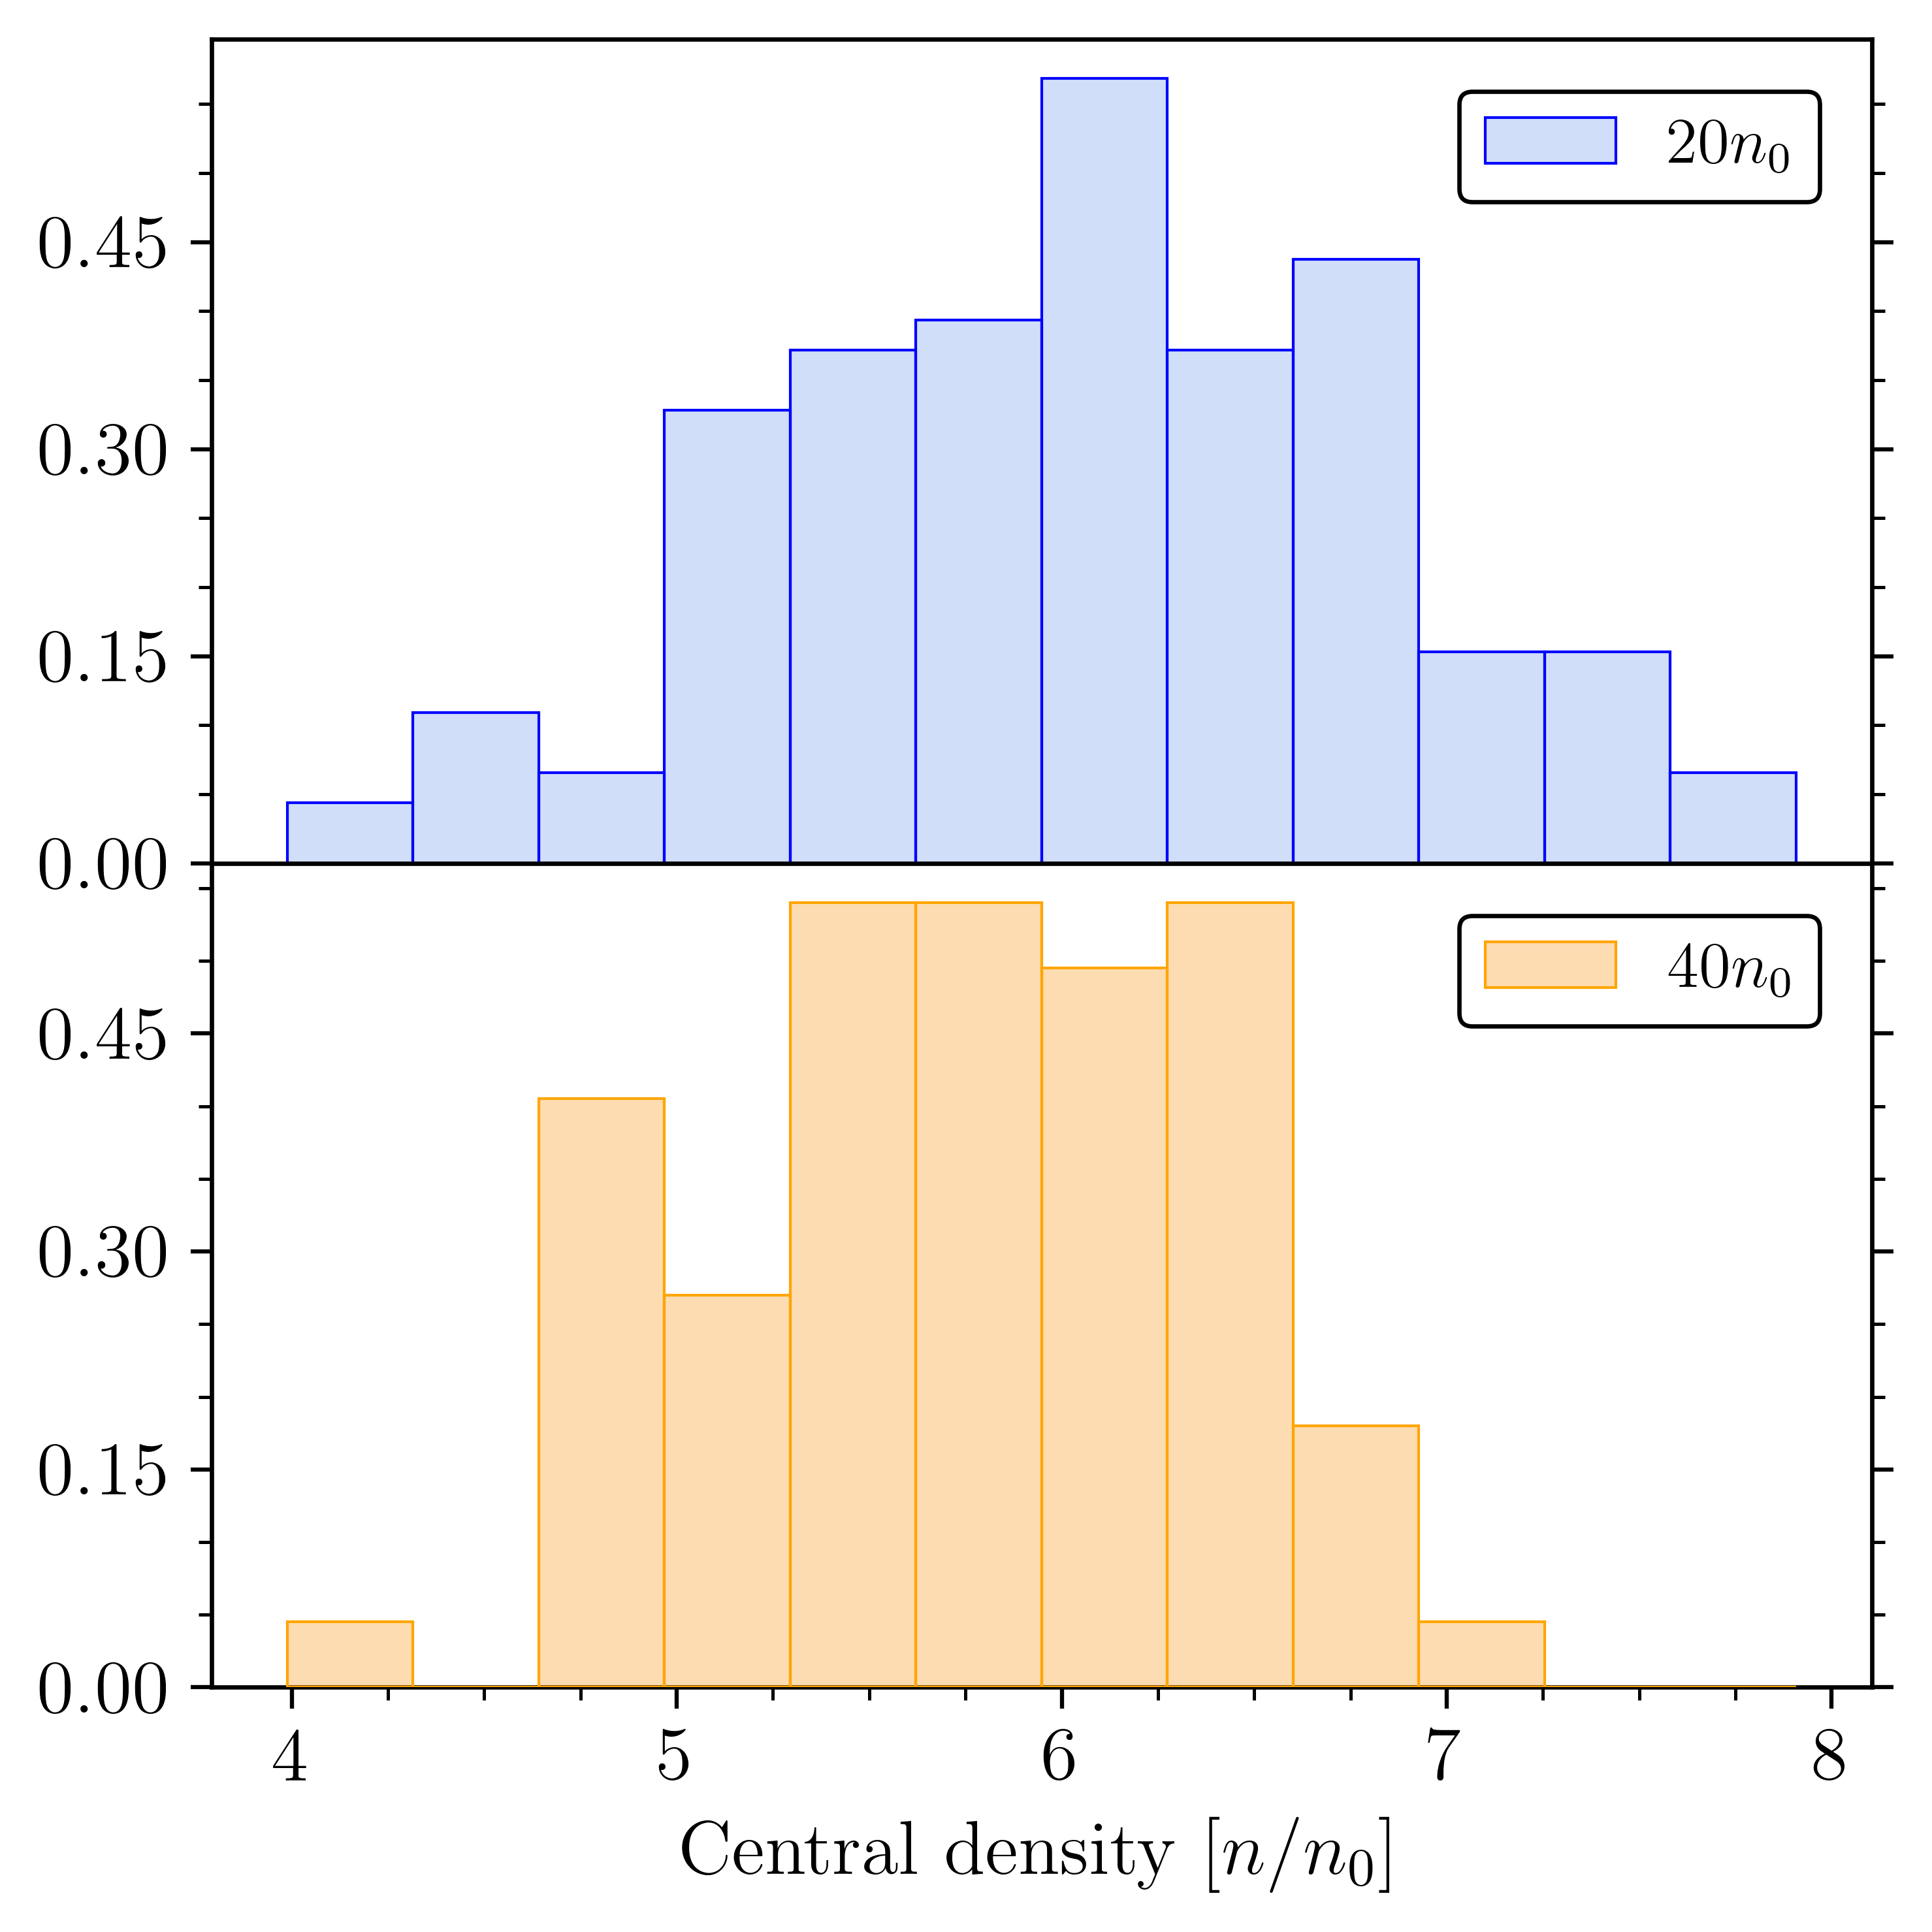

In [213]:
# bin the central densities and see what happens
fig, ax = plt.subplots(2, 1, figsize=(5,5), dpi=600, sharex=True, )
ax[0].tick_params(axis='both', which='major', direction='out', labelsize=14, right=True)
ax[0].tick_params(axis='both', which='minor', direction='out', labelsize=14, right=True)
ax[0].yaxis.set_major_locator(MultipleLocator(0.15))
ax[0].yaxis.set_minor_locator(AutoMinorLocator(3))
ax[0].xaxis.set_major_locator(MultipleLocator(1))
ax[0].xaxis.set_minor_locator(AutoMinorLocator(4))
ax[1].tick_params(axis='both', which='major', direction='out', labelsize=14, right=True)
ax[1].tick_params(axis='both', which='minor', direction='out', labelsize=14, right=True)
ax[1].yaxis.set_major_locator(MultipleLocator(0.15))
ax[1].yaxis.set_minor_locator(AutoMinorLocator(3))
ax[1].xaxis.set_major_locator(MultipleLocator(1))
ax[1].xaxis.set_minor_locator(AutoMinorLocator(4))

cdens_scaled = cdens_20_reduced/n0
cdens_scaled_40 = cdens_40_reduced/n0

# consistent binning
def freedman_diaconis_bin_width(data):
    q75, q25 = np.percentile(data, [75, 25])
    iqr = q75 - q25
    return 2 * iqr / np.cbrt(len(data))

# global dudes
maximum_cdens = max(max(cdens_scaled), max(cdens_scaled_40))
minimum_cdens = min(min(cdens_scaled), min(cdens_scaled_40))

bin_width = freedman_diaconis_bin_width(np.concatenate([cdens_scaled, cdens_scaled_40]))
bins = np.arange(minimum_cdens, maximum_cdens + bin_width, bin_width)

# 20n0 figure
n_20n0, bins_20n0, patches_20n0 = ax[0].hist(
    cdens_scaled, 
    bins=bins, 
    density=True, 
    edgecolor='blue',
    linewidth=0.5,
    label=r'$20n_{0}$',
    zorder=1
)

# 40n0 figure (separate for now)
n_40n0, bins_40n0, patches_40n0 = ax[1].hist(
    cdens_scaled_40,
    bins=bins,
    density=True,
    edgecolor='orange',
    linewidth=0.5,
    label=r'$40n_{0}$',
    zorder=10
)

for patch in patches_20n0:
    patch.set_facecolor((100/256, 149/256, 237/256, 0.3))  # cornflower blue
for patch in patches_40n0:
    patch.set_facecolor((255/256, 140/256, 0/256, 0.3))  # dark orange
ax[1].set_xlabel(r'Central density [$n/n_0$]', fontsize=14)
ax[0].legend(fontsize=12)
ax[1].legend(fontsize=12)
fig.tight_layout()
plt.subplots_adjust(hspace=0)
fig.savefig('histogram_central_densities_reduced.png')
plt.show()

/var/folders/q4/wyq6nf1d29n2gxrsbvs1m01r0000gn/T/ipykernel_9953/4064960880.py:43: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


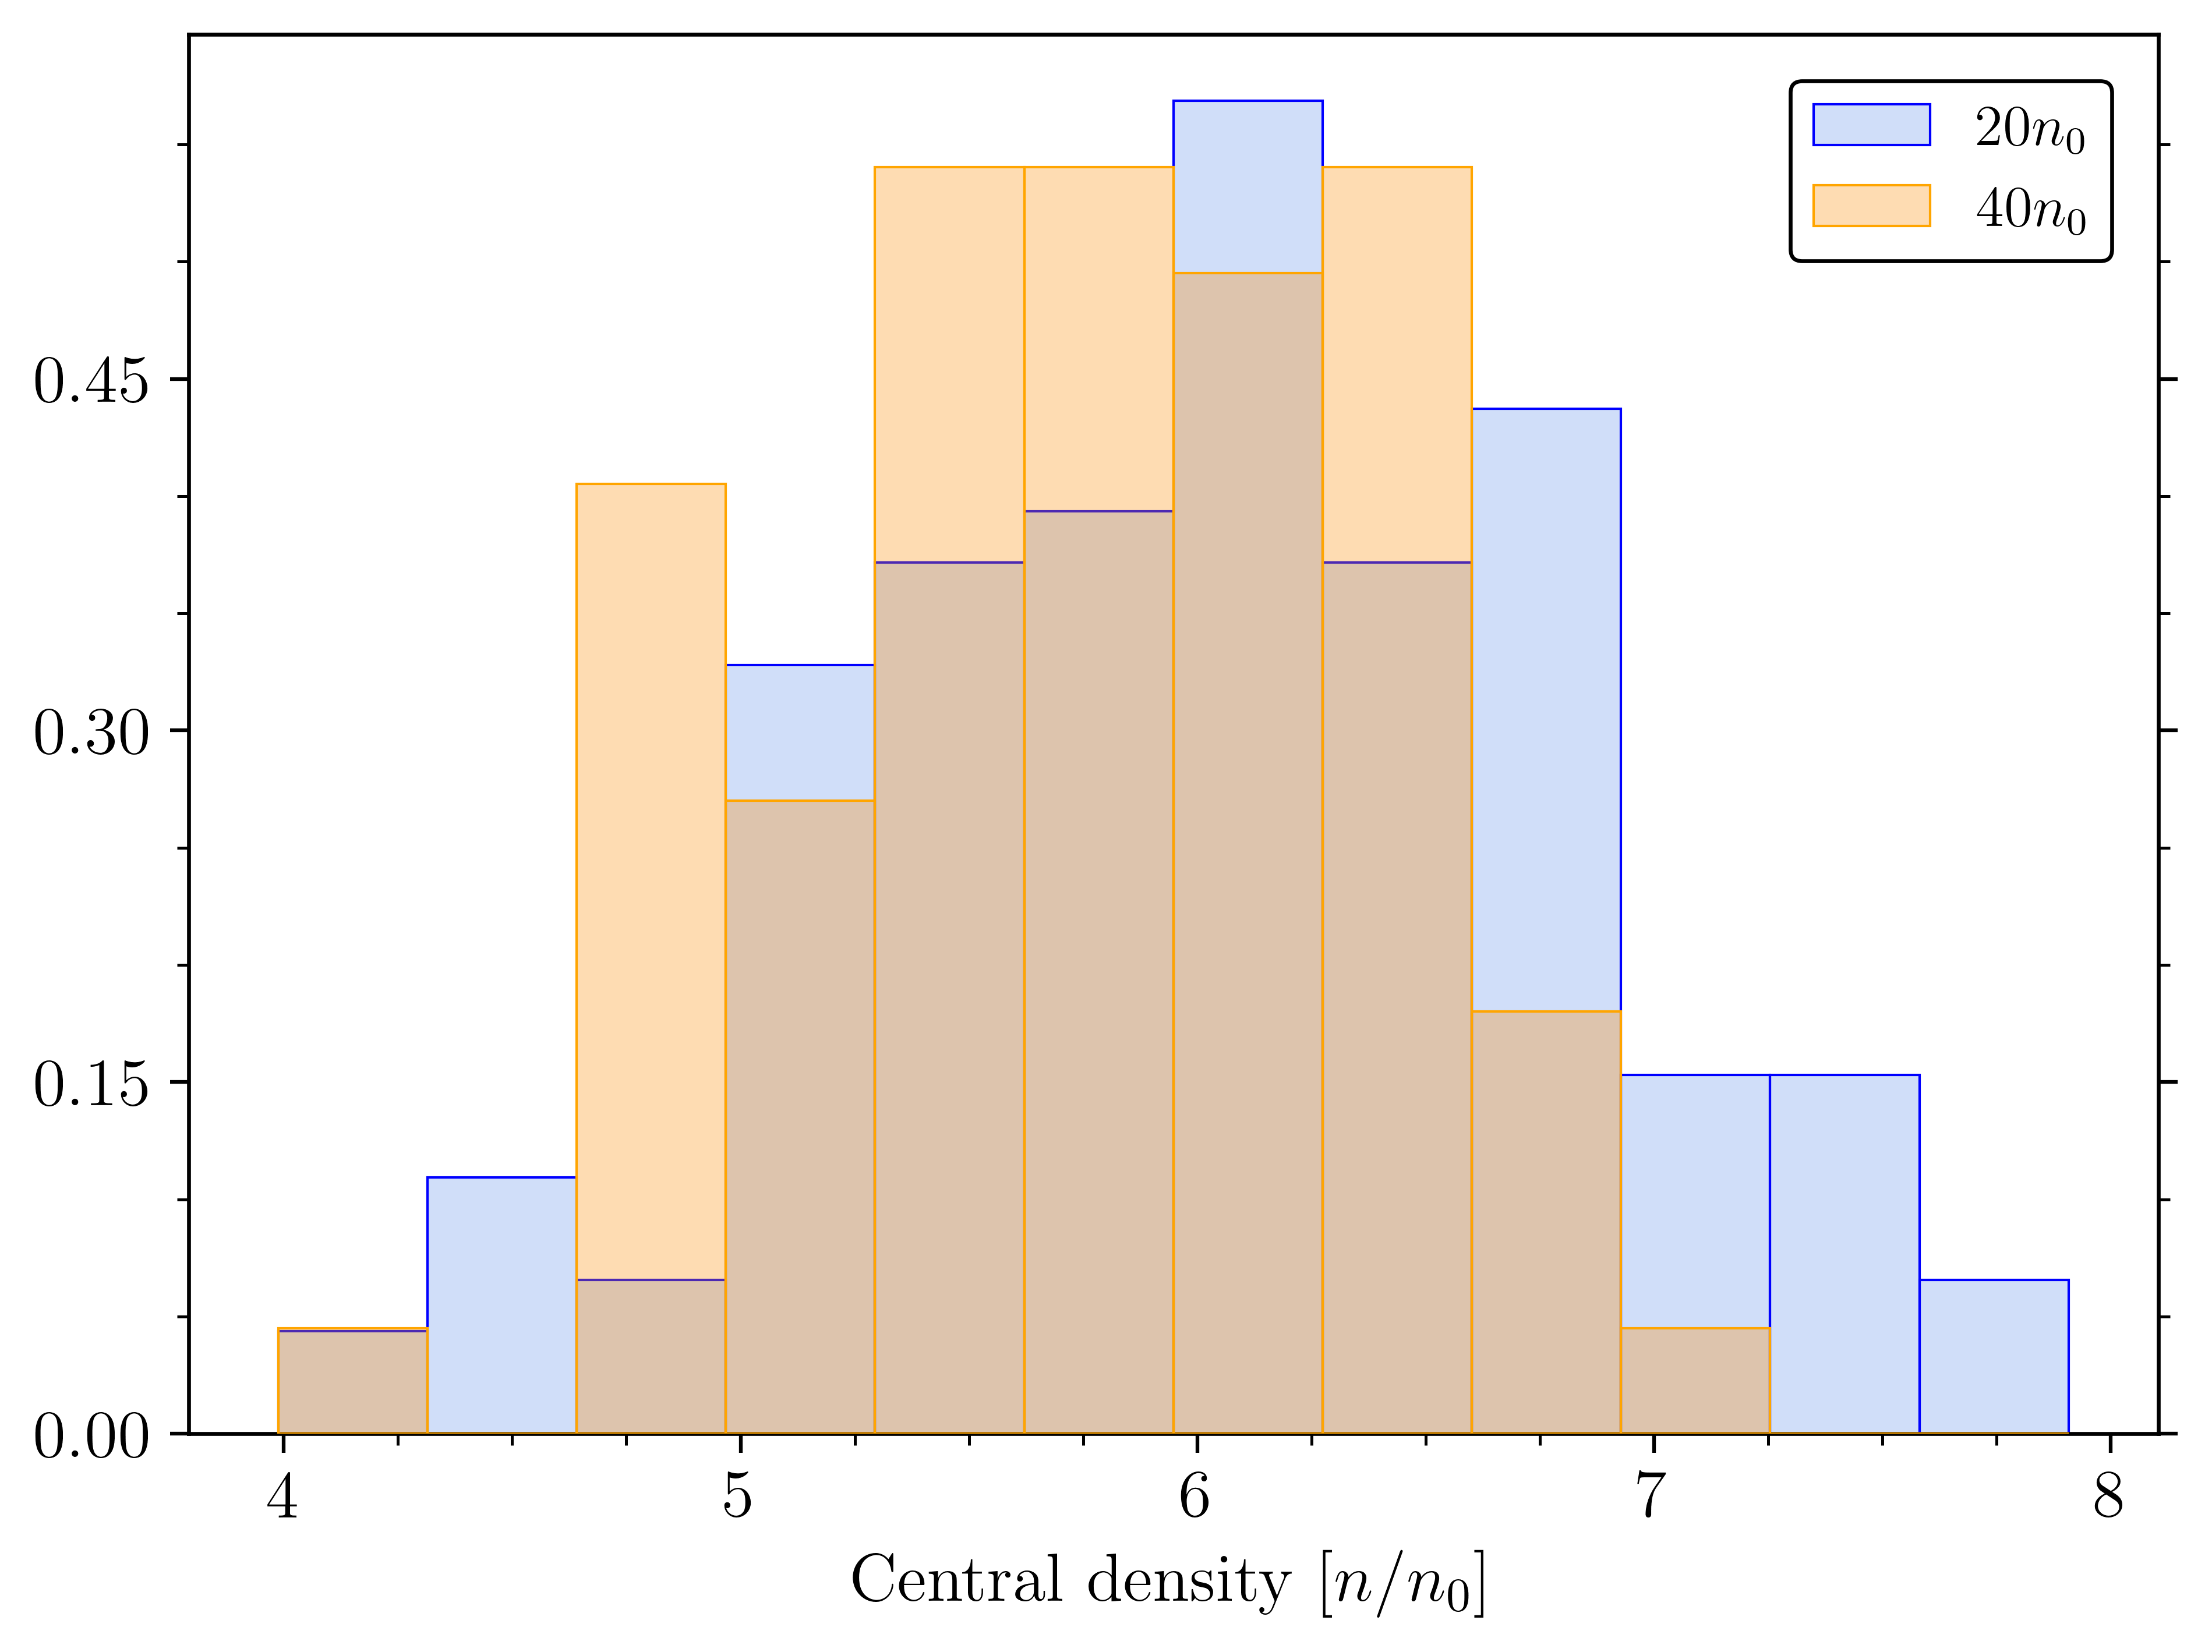

In [214]:
# combine back into one single plot
# bin the central densities and see what happens
fig = plt.figure(dpi=600)
ax = plt.axes()
ax.tick_params(axis='both', which='major', direction='out', labelsize=14, right=True)
ax.tick_params(axis='both', which='minor', direction='out', labelsize=14, right=True)
ax.yaxis.set_major_locator(MultipleLocator(0.15))
ax.yaxis.set_minor_locator(AutoMinorLocator(3))
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(AutoMinorLocator(4))

cdens_scaled = cdens_20_reduced/n0
cdens_scaled_40 = cdens_40_reduced/n0

# 20n0 figure
n_20n0, bins_20n0, patches_20n0 = ax.hist(
    cdens_scaled, 
    bins=bins, 
    density=True, 
    edgecolor='blue',
    linewidth=0.5,
    label=r'$20n_{0}$',
    zorder=1
)

# 40n0 figure (separate for now)
n_40n0, bins_40n0, patches_40n0 = ax.hist(
    cdens_scaled_40,
    bins=bins,
    density=True,
    edgecolor='orange',
    linewidth=0.5,
    label=r'$40n_{0}$',
    zorder=10
)

for patch in patches_20n0:
    patch.set_facecolor((100/256, 149/256, 237/256, 0.3))  # cornflower blue
for patch in patches_40n0:
    patch.set_facecolor((255/256, 140/256, 0/256, 0.3))  # dark orange
ax.set_xlabel(r'Central density [$n/n_0$]', fontsize=14)
ax.legend(fontsize=12)
fig.tight_layout()
plt.subplots_adjust(hspace=0)
fig.savefig('histogram_central_densities_reduced_one_plot.png')
plt.show()

In [7]:
# load the data for the overlay plot
stationary_20 = np.load('rpm_results_stationary_20n0.npz')
stationary_40 = np.load('rpm_results_stationary_40n0.npz')

# separate it all out
radius20n0 = stationary_20['radius']
cpres20n0 = stationary_20['central_pressure']
mass20n0 = stationary_20['mass']
maxrad20n0 = stationary_20['max_radius']
maxmass20n0 = stationary_20['max_mass']

radius40n0 = stationary_40['radius']
cpres40n0 = stationary_40['central_pressure']
mass40n0 = stationary_40['mass']
maxrad40n0 = stationary_40['max_radius']
maxmass40n0 = stationary_40['max_mass']

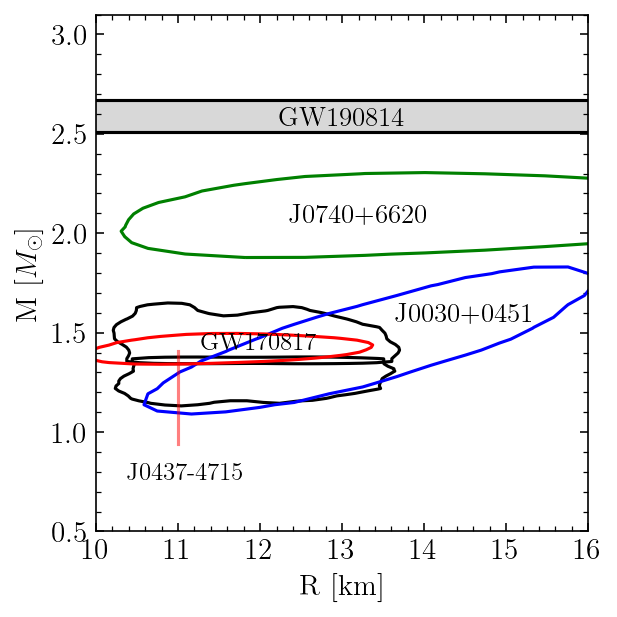

In [19]:
fig = plt.figure(figsize=(4,4), dpi=150)
ax = plt.axes()
corner.hist2d(x11, y11, bins=30, range=None, axes_scale=['linear', 'linear'], weights=None, \
              levels=[0.9], smooth=1.1, ax=ax, color=None, quiet=False, plot_datapoints=False, \
              plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
              contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
              new_fig=True, force_range=False)
corner.hist2d(x22, y22, bins=25, range=None, axes_scale=['linear', 'linear'], weights=None, \
              levels=[0.9], smooth=0.9, ax=ax, color=None, quiet=False, plot_datapoints=False, \
              plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
              contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
              new_fig=True, force_range=False)
corner.hist2d(miller[:,0], miller[:,1], bins=25, range=None, axes_scale=['linear', 'linear'], weights=None, \
              levels=[0.9], smooth=0.8, ax=ax, color='green', quiet=False, plot_datapoints=False, \
              plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
              contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
              new_fig=True, force_range=False)
corner.hist2d(miller_0030_2[:,0], miller_0030_2[:,1], bins=25, range=None, axes_scale=['linear', 'linear'], weights=None, \
              levels=[0.9], smooth=0.8, ax=ax, color='blue', quiet=False, plot_datapoints=False, \
              plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
              contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
              new_fig=True, force_range=False)
corner.hist2d(j0437[:,2], j0437[:,1], bins=25, range=None, axes_scale=['linear', 'linear'], weights=j0437[:,0], \
              levels=[0.9], smooth=0.8, ax=ax, color='red', quiet=False, plot_datapoints=False, \
              plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
              contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
              new_fig=True, force_range=False)
ax.text(13.2, 2.15, r'J0740+6620', ha='center', va='top', fontsize=13)
ax.text(14.5, 1.65, r'J0030+0451', ha='center', va='top', fontsize=13)
# GW 190814
fake_linspace = np.linspace(10.0, 16.0, 100)
gw_lower = 2.51*np.ones(len(fake_linspace))
gw_upper = 2.67*np.ones(len(fake_linspace))
ax.fill_between(fake_linspace, gw_lower, gw_upper, alpha=0.3, color='grey')
ax.axhline(y=2.51, color='k')
ax.axhline(y=2.67, color='k')
ax.text(13.0, 2.635, r'GW190814', ha='center', va='top', fontsize=13)
ax.set_ylim(0.5,3.1)
ax.set_xlim(10.0,16.0)
# ax.xaxis.set_major_locator(MultipleLocator(0.25))
ax.tick_params(right=True, top=True, which='both', labelsize=14)
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.set_xlabel(r'R [km]', fontsize=14)
ax.set_ylabel(r'M [$M_{\odot}$]', fontsize=14)
ax.text(12.0, 1.5, r'GW170817', ha='center', va='top', fontsize=12)
ax.axvline(x=11.0, ymin=0.17, ymax=0.35, color='red', alpha=0.5)
ax.text(11.1, 0.85, r'J0437-4715', ha='center', va='top', fontsize=12)
plt.show()
plt.show()

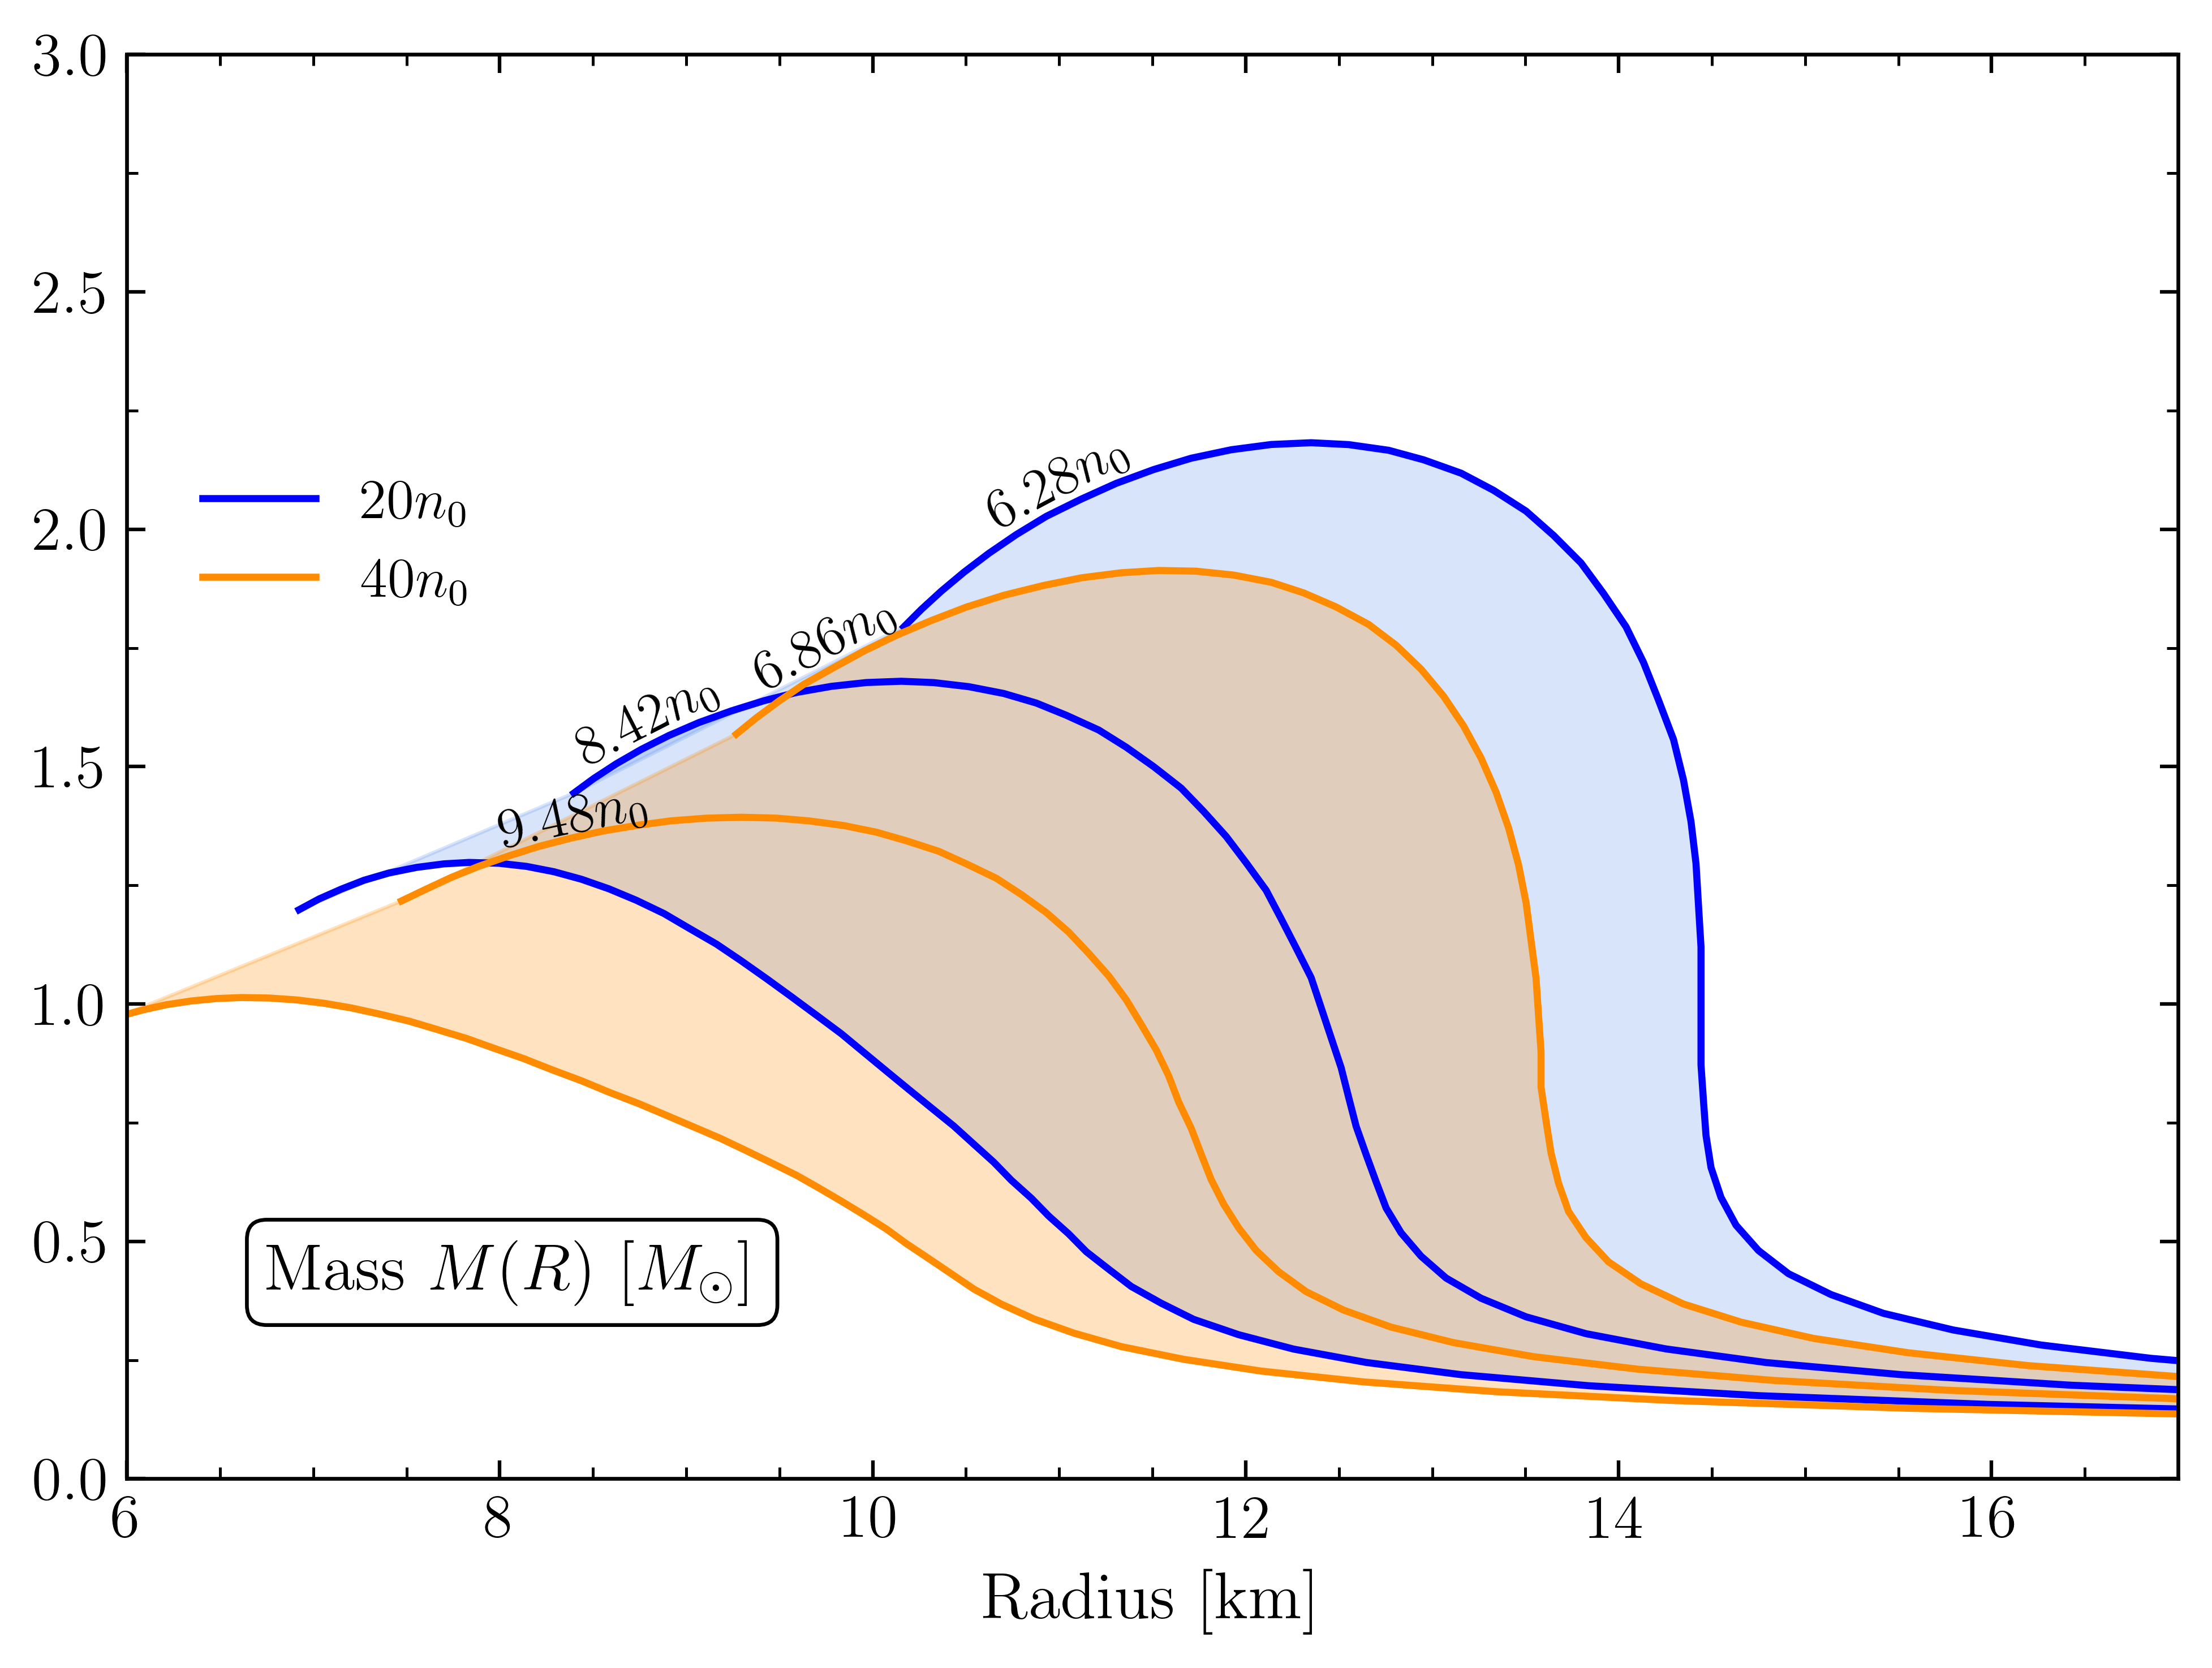

In [21]:
import matplotlib.patches as mpatches

# # define royal purple for contours
#royal_purple = '#9B30FF'

# plot the results including the samples and the overall mean, std_dev
fig, ax = plt.subplots(1,1, dpi=600)

# means
ax.plot(radius_data_mean_20, mass_data_mean_20, color='blue', label=r'$20n_{0}$')
ax.plot(radius_data_mean_40, mass_data_mean_40, color='darkorange', label=r'$40n_{0}$')

# 20n0
vertices = [(x, y1_val) for x, y1_val in zip(radius_data_mean_20[:,1], mass_data_mean_20[:,1])] + \
           [(x, y2_val) for x, y2_val in zip(reversed(radius_data_mean_20[:,2]), reversed(mass_data_mean_20[:,2]))]
vertices2 = [(x, y1_val) for x, y1_val in zip(radius_data_mean_20[:,0], mass_data_mean_20[:,0])] + \
           [(x, y2_val) for x, y2_val in zip(reversed(radius_data_mean_20[:,1]), reversed(mass_data_mean_20[:,1]))]

# 40n0
vertices40 = [(x, y1_val) for x, y1_val in zip(radius_data_mean_40[:,1], mass_data_mean_40[:,1])] + \
           [(x, y2_val) for x, y2_val in zip(reversed(radius_data_mean_40[:,2]), reversed(mass_data_mean_40[:,2]))]
vertices402 = [(x, y1_val) for x, y1_val in zip(radius_data_mean_40[:,0], mass_data_mean_40[:,0])] + \
           [(x, y2_val) for x, y2_val in zip(reversed(radius_data_mean_40[:,1]), reversed(mass_data_mean_40[:,1]))]

polygon = Polygon(vertices, closed=True, color="cornflowerblue", alpha=0.25)
polygon2 = Polygon(vertices2, closed=True, color="cornflowerblue", alpha=0.25)
plt.gca().add_patch(polygon)
plt.gca().add_patch(polygon2)

polygon40 = Polygon(vertices40, closed=True, color="darkorange", alpha=0.25)
polygon402 = Polygon(vertices402, closed=True, color="darkorange", alpha=0.25)
plt.gca().add_patch(polygon40)
plt.gca().add_patch(polygon402)

handles, labels = plt.gca().get_legend_handles_labels()

# remove duplicates by converting to a dictionary
unique = dict(zip(labels, handles))
legend = ax.legend(unique.values(), unique.keys(), fontsize=12, frameon=False, bbox_to_anchor=[0.2, 0.75])

# NICER and LIGO contours
# corner.hist2d(miller[:,0], miller[:,1], bins=25, range=None, axes_scale=['linear', 'linear'], weights=None, \
#               levels=[0.9], smooth=0.8, ax=ax, color='darkgreen', quiet=False, plot_datapoints=False, \
#               plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
#               contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
#               new_fig=False)
# corner.hist2d(miller_0030_2[:,0], miller_0030_2[:,1], bins=25, range=None, axes_scale=['linear', 'linear'], weights=None, \
#               levels=[0.9], smooth=0.8, ax=ax, color='royalblue', quiet=False, plot_datapoints=False, \
#               plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
#               contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
#               new_fig=False)
# corner.hist2d(x11, y11, bins=30, range=None, axes_scale=['linear', 'linear'], weights=None, \
#               levels=[0.9], smooth=1.1, ax=ax, color='maroon', quiet=False, plot_datapoints=False, \
#               plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
#               contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
#               new_fig=False)
# corner.hist2d(x22, y22, bins=25, range=None, axes_scale=['linear', 'linear'], weights=None, \
#               levels=[0.9], smooth=0.9, ax=ax, color='maroon', quiet=False, plot_datapoints=False, \
#               plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
#               contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
#               new_fig=False)
# corner.hist2d(j0437[:,2], j0437[:,1], bins=25, range=None, axes_scale=['linear', 'linear'], weights=j0437[:,0], \
#               levels=[0.9], smooth=0.8, ax=ax, color='red', quiet=False, plot_datapoints=False, \
#               plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
#               contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
#               new_fig=False)
    
# labels for LIGO and NICER data
# ax.text(13.2, 2.15, r'$\textbf{J0740+6620}$', ha='center', va='top', fontsize=13)
# ax.text(14.5, 1.65, r'$\textbf{J0030+0451}$', ha='center', va='top', fontsize=13)

# # GW 190814
# fake_linspace = np.linspace(6.0, 17.0, 100)
# gw_lower = 2.51*np.ones(len(fake_linspace))
# gw_upper = 2.67*np.ones(len(fake_linspace))
# ax.fill_between(fake_linspace, gw_lower, gw_upper, alpha=0.25, color='grey', hatch='/')
# ax.axhline(y=2.51, color='lightgrey')
# ax.axhline(y=2.67, color='lightgrey')
# ax.text(11.5, 2.635, r'$\textbf{GW190814}$', ha='center', va='top', fontsize=13)
# ax.text(12.0, 1.525, r'$\textbf{GW170817}$', ha='center', va='top', fontsize=13, zorder=10)
# ax.axvline(x=11.0, ymin=0.30, ymax=0.475, color='red', alpha=0.5)
# ax.text(11.1, 0.85, r'$\textbf{J0437-4715}$', ha='center', va='top', fontsize=13)

# adding labels for central densities of the top 2 curves
ax.text(8.4, 1.39, r'{:.2f}$n_0$'.format(cdens_mean_40[1]/n0), rotation=12, va='center', \
        ha='center', fontsize=12)
ax.text(9.75, 1.76, r'{:.2f}$n_0$'.format(cdens_mean_40[2]/n0), rotation=28, va='center', \
        ha='center', fontsize=12)

ax.text(8.8, 1.6, r'{:.2f}$n_0$'.format(cdens_mean_20[1]/n0), rotation=27, va='center', \
        ha='center', fontsize=12)
ax.text(11.0, 2.1, r'{:.2f}$n_0$'.format(cdens_mean_20[2]/n0), rotation=28, va='center', \
        ha='center', fontsize=12)

ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.tick_params(axis='both', which='major', labelsize=13, right=True, top=True)
ax.tick_params(axis='both', which='minor', labelsize=13, right=True, top=True)
ax.set_xlim(6.0, 17.0)
ax.set_ylim(0.0,3.0)
ax.set_xlabel(r'Radius [km]', fontsize=14)
ax.text(6.75, 0.40, r'Mass $M(R)$ $[M_\odot]$', fontsize=14, bbox=dict(facecolor='w', boxstyle='round'))
fig.savefig('basic_overlay_mr_curves.png')
plt.show()

# extract the contour, see if we can use it for the selection of curves!
# contour_collections = ax.collections
# contours = contour_collections[:2]

# vertices = []
# for contour in contours:
#     for path in contour.get_paths():
#         vertices.append(path.vertices)
        
# vertices_first = np.asarray(vertices)[0]

In [22]:
# write central densities
print(cdens_mean_20/n0)
print(cdens_mean_40/n0)

[12.87840579  8.41507544  6.27853489]
[17.37175092  9.47951654  6.85772183]
